# Deep Neural Networks Laboration

Data used in this laboration are from the Kitsune Network Attack Dataset, https://archive.ics.uci.edu/ml/datasets/Kitsune+Network+Attack+Dataset . We will focus on the 'Mirai' part of the dataset. Your task is to make a DNN that can classify if each attack is benign or malicious. The dataset has 116 covariates, but to make it a bit more difficult we will remove the first 24 covariates.

You need to answer all questions in this notebook.

If the training is too slow on your own computer, use the smaller datasets (*half or *quarter).

Dense networks are not optimal for tabular datasets like the one used here, but here the main goal is to learn deep learning.

# Part 1: Get the data

Skip this part if you load stored numpy arrays (Mirai*.npy) (which is recommended)

Use `wget` in the terminal of your cloud machine (in the same directory as where you have saved this notebook) to download the data, i.e.

wget https://archive.ics.uci.edu/ml/machine-learning-databases/00516/mirai/Mirai_dataset.csv.gz

wget https://archive.ics.uci.edu/ml/machine-learning-databases/00516/mirai/Mirai_labels.csv.gz

Then unpack the files using `gunzip` in the terminal, i.e.

gunzip Mirai_dataset.csv.gz

gunzip Mirai_labels.csv.gz

# Part 2: Get a graphics card

Skip this part if you run on the CPU (recommended)

Lets make sure that our script can see the graphics card that will be used. The graphics cards will perform all the time consuming calculations in every training iteration.

In [2]:
import os
import warnings

# Ignore FutureWarning from numpy
warnings.simplefilter(action='ignore', category=FutureWarning)

import keras.backend as K
import tensorflow as tf

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

# Allow growth of GPU memory, otherwise it will always look like all the memory is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True) 


# Check if any GPU is detected
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("No GPU detected. The code will run on CPU.")

No GPU detected. The code will run on CPU.


# Part 3: Hardware

In deep learning, the computer hardware is very important. You should always know what kind of hardware you are working on. Lets pretend that everyone is using an Nvidia RTX 3090 graphics card.

Question 1: Google the name of the graphics card, how many CUDA cores does it have?

<span style="color:blue">The Nvidia RTX 3090 graphics card has 10,496 CUDA cores1</span>
 
<span style="color:blue">reference: https://www.nvidia.com/sv-se/geforce/graphics-cards/30-series/rtx-3090-3090ti/</span>

Question 2: How much memory does the graphics card have?

<span style="color:blue">The Nvidia RTX 3090 graphics card has 24 GB of GDDR6X memory</span>

Question 3: What is stored in the GPU memory while training a DNN ?

<span style="color:blue">While training a Deep Neural Network (DNN), the GPU memory stores the following:</span>

<span style="color:blue">Model Parameters: These include the weights and biases for each layer in the network.</span>

<span style="color:blue">Intermediate Computations: The outputs of each layer in the network are stored for backpropagation.</span>

<span style="color:blue">Optimizer States: If the optimizer maintains a state (like in Adam or RMSprop), these are also stored in the GPU memory.</span>

<span style="color:blue">Mini-batch Data: The input data for the current mini-batch is loaded into GPU memory.</span>

# Part 4: Load the data

To make this step easier, directly load the data from saved numpy arrays (.npy) (recommended)


Load the dataset from the csv files, it will take some time since it is almost 1.4 GB. (not recommended, unless you want to learn how to do it)

We will use the function `genfromtxt` to load the data. (not recommended, unless you want to learn how to do it)

https://docs.scipy.org/doc/numpy/reference/generated/numpy.genfromtxt.html

Load the data from csv files the first time, then save the data as numpy files for faster loading the next time.

Remove the first 24 covariates to make the task harder.

In [65]:
from numpy import genfromtxt # Not needed if you load data from numpy arrays
import numpy as np

# Load data from numpy arrays, choose reduced files if the training takes too long
X = np.load('Mirai_data.npy')
Y = np.load('Mirai_labels.npy')



# Remove the first 24 covariates (columns)
X = X[:, 24:]

print('The covariates have size {}.'.format(X.shape))
print('The labels have size {}.'.format(Y.shape))

# Print the number of examples of each class    
unique, counts = np.unique(Y, return_counts=True)
for unique_classe, count in zip(unique, counts):
    print(f"Class {int(unique_classe)}: {count} examples")

The covariates have size (764137, 92).
The labels have size (764137,).
Class 0: 121621 examples
Class 1: 642516 examples


# Part 5: How good is a naive classifier?

Question 4: Given the number of examples from each class, how high classification performance can a naive classifier obtain? The naive classifier will assume that all examples belong to one class. Note: you do not need to make a naive classifier, this is a theoretical question, just to understand how good performance we can obtain by guessing that all examples belong to one class.

In all classification tasks you should always ask these questions

- How good classification accuracy can a naive classifier obtain? The naive classifier will assume that all examples belong to one class.
- What is random chance classification accuracy if you randomly guess the label of each (test) example? For a balanced dataset and binary classification this is easy (50%), but in many cases it is more complicated and a Monte Carlo simulation may be required to estimate random chance accuracy.

If your classifier cannot perform better than a naive classifier or a random classifier, you are doing something wrong.


In [66]:
# It is common to have NaNs in the data, lets check for it. Hint: np.isnan()
most_common_class_count = max(counts)
total_examples = sum(counts)
naive_classifier_accuracy = most_common_class_count / total_examples
print(f"A naive classifier, which always predicts the most common class, would have an accuracy of {naive_classifier_accuracy}.")

# Print the number of NaNs (not a number) in the labels
nan_in_labels = np.isnan(Y).sum()
nan_in_covariates = np.isnan(X).sum()


# Print the number of NaNs in the covariates
print(f"The labels have {nan_in_labels} NaNs.")
print(f"The covariates have {nan_in_covariates} NaNs.")



A naive classifier, which always predicts the most common class, would have an accuracy of 0.8408387501194158.
The labels have 0 NaNs.
The covariates have 0 NaNs.


# Part 6: Preprocessing

Lets do some simple preprocessing

In [67]:
# Convert covariates to floats
X = X.astype(float)

# Convert labels to integers
Y = Y.astype(int)

# Remove mean of each covariate (column)
X = X - np.mean(X, axis=0)


# Divide each covariate (column) by its standard deviation
X = X / np.std(X, axis=0)

# Check that mean is 0 and standard deviation is 1 for all covariates, by printing mean and std
print('Mean:', np.mean(X, axis=0))
print('Standard deviation:', np.std(X, axis=0))


Mean: [-3.19451533e-18 -6.32970181e-14  1.19926356e-13  4.56743018e-15
  4.10210037e-14  1.46130975e-13  5.85246484e-16 -1.69734859e-14
 -3.36915700e-13  1.28688437e-12 -2.69360995e-12 -1.10733213e-13
 -1.22392702e-13 -1.70649630e-13 -1.02461166e-14  2.50701280e-12
  1.47553162e-12  1.08446837e-12 -1.04981959e-13  6.83458762e-14
 -1.03373555e-13  5.98825773e-14 -1.02025960e-12 -1.68983055e-12
 -1.79101143e-12 -1.31828514e-13  4.42580403e-13  6.14635580e-13
  5.78048199e-14 -4.92623328e-13 -2.54513072e-12  1.86544900e-13
 -1.53444593e-13  1.68079591e-12  9.30041709e-13  1.50738177e-13
 -1.15688852e-12 -3.62610361e-13 -1.71390937e-12 -2.09264067e-13
  1.07161976e-12 -1.45236885e-12 -1.69724579e-14 -1.64918984e-16
 -5.13444996e-14 -1.02171349e-14 -1.74685907e-15  1.34264921e-13
  5.98801969e-14  1.48745574e-17 -4.25442340e-13  5.78079594e-14
  1.25638129e-15  1.69449684e-13  1.50725881e-13  2.14439542e-14
  3.65457183e-14  1.17260451e-13 -8.82752870e-13 -6.34816648e-13
 -1.62109649e-12  2

# Part 7: Split the dataset

Use the first 70% of the dataset for training, leave the other 30% for validation and test, call the variables

Xtrain (70%)

Xtemp  (30%)

Ytrain (70%)

Ytemp  (30%)

We use a function from scikit learn.
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html


In [71]:
from sklearn.model_selection import train_test_split

# Your code to split the dataset
Xtrain, Xtemp, Ytrain, Ytemp = train_test_split(X, Y, test_size=0.3, random_state=42)


print('Xtrain has size {}.'.format(Xtrain.shape))
print('Ytrain has size {}.'.format(Ytrain.shape))

print('Xtemp has size {}.'.format(Xtemp.shape))
print('Ytemp has size {}.'.format(Ytemp.shape))

# Print the number of examples of each class, for the training data and the remaining 30%
unique_train, counts_train = np.unique(Ytrain, return_counts=True)
print("\nNumber of examples of each class in the training data: ")
for unique_train_class, count_train in zip(unique_train, counts_train):
    print(f"Class {int(unique_train_class)}: {count_train} examples")

    
unique_temp, counts_temp = np.unique(Ytemp, return_counts=True)
print("\nNumber of examples of each class in the remaining 30% data: ")
for unique_temp_class, count_temp in zip(unique_temp, counts_temp):
    print(f"Class {int(unique_temp_class)}: {count_temp} examples")


Xtrain has size (534895, 92).
Ytrain has size (534895,).
Xtemp has size (229242, 92).
Ytemp has size (229242,).

Number of examples of each class in the training data: 
Class 0: 85248 examples
Class 1: 449647 examples

Number of examples of each class in the remaining 30% data: 
Class 0: 36373 examples
Class 1: 192869 examples


#  Part 8: Split non-training data data into validation and test
Now split your non-training data (Xtemp, Ytemp) into 50% validation (Xval, Yval) and 50% testing (Xtest, Ytest), we use a function from scikit learn. In total this gives us 70% for training, 15% for validation, 15% for test.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

Do all variables (Xtrain,Ytrain), (Xval,Yval), (Xtest,Ytest) have the shape that you expect?

In [7]:
from sklearn.model_selection import train_test_split

# Your code
Xval, Xtest, Yval, Ytest = train_test_split(Xtemp, Ytemp, test_size=0.5, random_state=42)

unique_val, counts_val = np.unique(Yval, return_counts=True)
print("Number of examples of each class in the validation data: ", dict(zip(unique_val, counts_val)))

unique_test, counts_test = np.unique(Ytest, return_counts=True)
print("Number of examples of each class in the test data: ", dict(zip(unique_test, counts_test)))

print('The validation and test data have size {}, {}, {} and {}'.format(Xval.shape, Xtest.shape, Yval.shape, Ytest.shape))

Number of examples of each class in the validation data:  {0: 18291, 1: 96330}
Number of examples of each class in the test data:  {0: 18082, 1: 96539}
The validation and test data have size (114621, 92), (114621, 92), (114621,) and (114621,)


# Part 9: DNN classification

Finish this code to create a first version of the classifier using a DNN. Start with a simple network with 2 dense layers (with 20 nodes each), using sigmoid activation functions. The final dense layer should have a single node and a sigmoid activation function. We start with the SGD optimizer.

For different parts of this notebook you need to go back here, add more things, and re-run this cell to re-define the build function.

Relevant functions are

`model.add()`, adds a layer to the network

`Dense()`, a dense network layer

`model.compile()`, compile the model, add " metrics=['accuracy'] " to print the classification accuracy during the training

See https://keras.io/layers/core/ for information on how the `Dense()` function works

Import a relevant cost / loss function for binary classification from keras.losses (https://keras.io/losses/)

See the following links for how to compile, train and evaluate the model

https://keras.io/api/models/model_training_apis/#compile-method

https://keras.io/api/models/model_training_apis/#fit-method

https://keras.io/api/models/model_training_apis/#evaluate-method

Make sure that the last layer always has a sigmoid activation function (why?).


In [77]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense
from tensorflow.keras.optimizers import SGD
from keras.losses import SparseCategoricalCrossentropy

# Set seed from random number generator, for better comparisons
from numpy.random import seed
seed(123)

def build_DNN(input_shape, n_layers, n_nodes, act_fun='sigmoid', optimizer='sgd', learning_rate=0.01, 
              use_bn=False, use_dropout=False, use_custom_dropout=False):
    
    # Setup optimizer, depending on input parameter string
    if optimizer == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
        
    # Setup a sequential model
    model = Sequential()

    
    # Add first layer, requires input shape
    model.add(Dense(n_nodes, activation=act_fun, input_shape=input_shape))
    
    # Add remaining layers, do not require input shape
    for i in range(n_layers-1):
        model.add(Dense(n_nodes, activation=act_fun))
    
    
    # Add final layer
    model.add(Dense(1, activation='sigmoid'))  
    
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [78]:
# Lets define a help function for plotting the training results

import matplotlib.pyplot as plt
def plot_results(history):
    
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    
    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training','Validation'])

    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training','Validation'])

    plt.show()

# Part 10: Train the DNN

Time to train the DNN, we start simple with 2 layers with 20 nodes each, learning rate 0.1.

Relevant functions

`build_DNN`, the function we defined in Part 9, call it with the parameters you want to use

`model.fit()`, train the model with some training data

`model.evaluate()`, apply the trained model to some test data

See the following links for how to train and evaluate the model

https://keras.io/api/models/model_training_apis/#fit-method

https://keras.io/api/models/model_training_apis/#evaluate-method


Make sure that you are using learning rate 0.1 !

### 2 layers, 20 nodes

In [79]:
# Setup some training parameters
batch_size = 10000
epochs = 20

input_shape = (Xtrain.shape[1],)

# Build the model
model1 = build_DNN(input_shape, n_layers=2, n_nodes=20, learning_rate=0.1)

# Train the model, provide training data and validation data
history1 =  model1.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(Xval, Yval))

Epoch 1/20
54/54 [==============================] - 2s 24ms/step - loss: 0.4437 - accuracy: 0.8155 - val_loss: 0.3910 - val_accuracy: 0.8404
Epoch 2/20
54/54 [==============================] - 0s 8ms/step - loss: 0.3692 - accuracy: 0.8406 - val_loss: 0.3446 - val_accuracy: 0.8404
Epoch 3/20
54/54 [==============================] - 0s 8ms/step - loss: 0.3191 - accuracy: 0.8406 - val_loss: 0.2918 - val_accuracy: 0.8404
Epoch 4/20
54/54 [==============================] - 0s 7ms/step - loss: 0.2696 - accuracy: 0.8406 - val_loss: 0.2477 - val_accuracy: 0.8403
Epoch 5/20
54/54 [==============================] - 0s 6ms/step - loss: 0.2339 - accuracy: 0.8527 - val_loss: 0.2203 - val_accuracy: 0.8658
Epoch 6/20
54/54 [==============================] - 0s 7ms/step - loss: 0.2134 - accuracy: 0.8793 - val_loss: 0.2053 - val_accuracy: 0.8927
Epoch 7/20
54/54 [==============================] - 0s 7ms/step - loss: 0.2020 - accuracy: 0.8957 - val_loss: 0.1967 - val_accuracy: 0.9025
Epoch 8/20
54/54 [=

In [80]:
# Evaluate the model on the test data
score = model1.evaluate(Xtest, Ytest, verbose=0)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 0.1714
Test accuracy: 0.9093


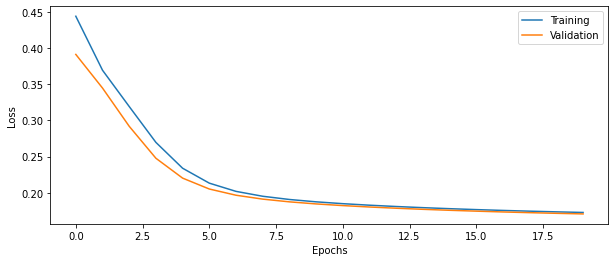

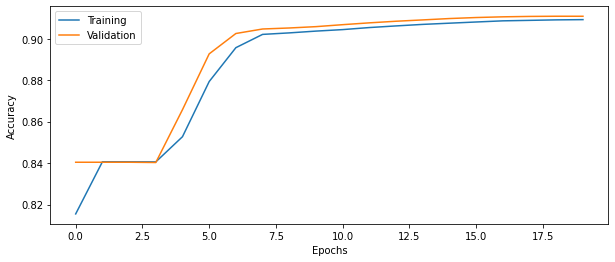

In [81]:
# Plot the history from the training run
plot_results(history1)

# Part 11: More questions

Question 5: What happens if you add several Dense layers without specifying the activation function?

<span style="color:blue">If adding several Dense layers in Keras without specifying an activation function, the layers will have a linear activation function by default in Keras. This means that they will not apply any activation function to their input, they will just pass it on. If stacking several of these layers together, they will still behave as a single layer, because the composition of linear functions is still a linear function. This is why it’s important to add a non-linear activation function between the Dense layers: it allows the stack of layers to model more complex patterns.</span>


Question 6: How are the weights in each dense layer initialized as default? How are the bias weights initialized?

<span style="color:blue">In Keras, the weights in each Dense layer are initialized using ‘Glorot Uniform’ initializer, also known as the Xavier uniform initializer. It draws samples from a uniform distribution within [-limit, limit], where limit is sqrt(6 / (fan_in + fan_out)) and fan_in is the number of input units in the weight tensor and fan_out is the number of output units. The bias weights in each Dense layer are initialized with zeros by default. This is a common and safe practice because the bias terms are independent of the input data, and setting them to zero doesn’t prevent the model from learning appropriate bias values during training.</span>


# Part 12: Balancing the classes

This dataset is rather unbalanced, we need to define class weights so that the training pays more attention to the class with fewer samples. We use a function in scikit learn

https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html

You need to call the function something like this

class_weights = class_weight.compute_class_weight(class_weight = , classes = , y = )

otherwise it will complain

In [82]:
from sklearn.utils import class_weight

# Calculate class weights
class_weights = class_weight.compute_class_weight('balanced', np.unique(Ytrain), Ytrain)


# Print the class weights
print("Class weights: ", class_weights)

# Keras wants the weights in this form, uncomment and change value1 and value2 to your weights, 
# or get them from the array that is returned from class_weight

class_weights = {i : class_weights[i] for i in range(len(class_weights))}

print("Class weights in Keras format: ", class_weights)

Class weights:  [3.13728768 0.59479436]
Class weights in Keras format:  {0: 3.1372876783033035, 1: 0.5947943609097803}


### 2 layers, 20 nodes, class weights

In [83]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (Xtrain.shape[1],) 

# Build and train model
model2 = build_DNN(input_shape, n_layers=2, n_nodes=20, learning_rate=0.1)

history2 = model2.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(Xval, Yval), class_weight=class_weights)

Epoch 1/20
54/54 [==============================] - 2s 19ms/step - loss: 0.6278 - accuracy: 0.8095 - val_loss: 0.5582 - val_accuracy: 0.8813
Epoch 2/20
54/54 [==============================] - 0s 8ms/step - loss: 0.4577 - accuracy: 0.8795 - val_loss: 0.3998 - val_accuracy: 0.8815
Epoch 3/20
54/54 [==============================] - 0s 8ms/step - loss: 0.3244 - accuracy: 0.8796 - val_loss: 0.3180 - val_accuracy: 0.8816
Epoch 4/20
54/54 [==============================] - 0s 7ms/step - loss: 0.2645 - accuracy: 0.8797 - val_loss: 0.2895 - val_accuracy: 0.8816
Epoch 5/20
54/54 [==============================] - 0s 7ms/step - loss: 0.2407 - accuracy: 0.8797 - val_loss: 0.2766 - val_accuracy: 0.8816
Epoch 6/20
54/54 [==============================] - 0s 7ms/step - loss: 0.2292 - accuracy: 0.8797 - val_loss: 0.2697 - val_accuracy: 0.8817
Epoch 7/20
54/54 [==============================] - 0s 7ms/step - loss: 0.2225 - accuracy: 0.8798 - val_loss: 0.2655 - val_accuracy: 0.8818
Epoch 8/20
54/54 [=

In [84]:
# Evaluate model on test data
score = model2.evaluate(Xtest, Ytest, verbose=0)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 0.2362
Test accuracy: 0.8972


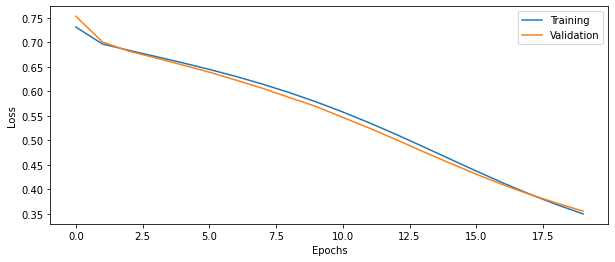

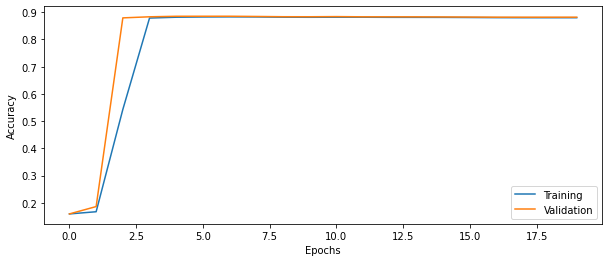

In [20]:
plot_results(history2)

# Part 13: More questions

Skip questions 8 and 9 if you run on the CPU (recommended)

Question 7: Why do we have to use a batch size? Why can't we simply use all data at once? This is more relevant for even larger datasets.

<span style="color:blue">We use a batch size because it’s not feasible to fit all data into memory at once, especially for large datasets. Also, using smaller batches makes the network update weights more frequently, leading to a faster convergence, and introduces some noise into the learning process, helping the model avoid local minima.</span>

Question 8: How busy is the GPU for a batch size of 100? How much GPU memory is used? Hint: run 'nvidia-smi' on the computer a few times during training.

Question 9: What is the processing time for one training epoch when the batch size is 100? What is the processing time for one epoch when the batch size is 1,000? What is the processing time for one epoch when the batch size is 10,000? Explain the results. 

Question 10: How many times are the weights in the DNN updated in each training epoch if the batch size is 100? How many times are the weights in the DNN updated in each training epoch if the batch size is 1,000? How many times are the weights in the DNN updated in each training epoch if the batch size is 10,000?  

<span style="color:blue">The weights in the DNN are updated after each batch is processed. So, if the batch size is 100, and having 10,000 examples, the weights are updated 10,000 / 100 = 100 times per epoch. Similarly, for batch sizes of 1,000 and 10,000, the weights would be updated 10 and 1 times per epoch, respectively.</span>

Question 11: What limits how large the batch size can be?

<span style="color:blue">The maximum batch size is limited by the memory capacity of the hardware. If trying to use a batch size that is too large, it will run out of memory.</span>

Question 12: Generally speaking, how is the learning rate related to the batch size? If the batch size is decreased, how should the learning rate be changed?

<span style="color:blue">If the batch size is decreased, the learning rate should also be decreased. This is because with a smaller batch size, the gradient estimate will have higher variance, and a high learning rate can amplify this variance, leading to unstable training.</span>

Lets use a batch size of 10,000 from now on, and a learning rate of 0.1.

# Part 14: Increasing the complexity

Lets try some different configurations of number of layers and number of nodes per layer.

Question 13: How many trainable parameters does the network with 4 dense layers with 50 nodes each have, compared to the initial network with 2 layers and 20 nodes per layer? Hint: use model.summary()

<span style="color:blue"> * number_of_nodes. The “+1” is due to the bias terms, one for each node. For a network with 2 layers and 20 nodes per layer, assuming the input has n features:</span>

<span style="color:blue"> The first layer has (n + 1) * 20 parameters.</span>
<span style="color:blue"> The second layer has (20 + 1) * 20 parameters (since the input to this layer is the output of the first layer, which has 20 nodes).</span>

<span style="color:blue"> For a network with 4 layers and 50 nodes per layer:</span>

<span style="color:blue"> The first layer has (n + 1) * 50 parameters.</span>
<span style="color:blue"> Each of the next three layers has (50 + 1) * 50 parameters.</span>

### 4 layers, 20 nodes, class weights

In [85]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (Xtrain.shape[1],)

# Build and train model
model3 = build_DNN(input_shape, n_layers=4, n_nodes=20, learning_rate=0.1)

history3 = model3.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(Xval, Yval), class_weight=class_weights)

Epoch 1/20
54/54 [==============================] - 2s 18ms/step - loss: 0.6937 - accuracy: 0.5854 - val_loss: 0.6914 - val_accuracy: 0.8512
Epoch 2/20
54/54 [==============================] - 1s 10ms/step - loss: 0.6923 - accuracy: 0.5460 - val_loss: 0.6899 - val_accuracy: 0.8532
Epoch 3/20
54/54 [==============================] - 1s 10ms/step - loss: 0.6915 - accuracy: 0.6601 - val_loss: 0.6925 - val_accuracy: 0.7150
Epoch 4/20
54/54 [==============================] - 1s 10ms/step - loss: 0.6907 - accuracy: 0.6827 - val_loss: 0.6930 - val_accuracy: 0.4720
Epoch 5/20
54/54 [==============================] - 1s 11ms/step - loss: 0.6897 - accuracy: 0.7551 - val_loss: 0.6865 - val_accuracy: 0.8720
Epoch 6/20
54/54 [==============================] - 1s 10ms/step - loss: 0.6886 - accuracy: 0.8202 - val_loss: 0.6868 - val_accuracy: 0.8790
Epoch 7/20
54/54 [==============================] - 1s 10ms/step - loss: 0.6872 - accuracy: 0.8762 - val_loss: 0.6930 - val_accuracy: 0.4355
Epoch 8/20
54

In [86]:
# Evaluate model on test data
score = model3.evaluate(Xtest, Ytest, verbose=0)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 0.2760
Test accuracy: 0.8796


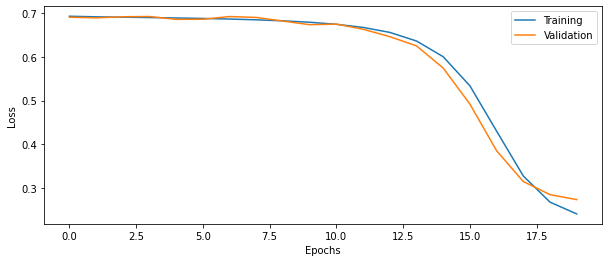

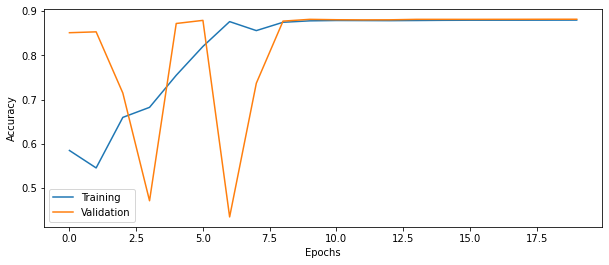

In [87]:
plot_results(history3)

### 2 layers, 50 nodes, class weights

In [88]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (Xtrain.shape[1],)

# Build and train model
model4 = build_DNN(input_shape, n_layers=2, n_nodes=50, learning_rate=0.1)

history4 = model4.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(Xval, Yval), class_weight=class_weights)

Epoch 1/20
54/54 [==============================] - 4s 59ms/step - loss: 0.5961 - accuracy: 0.7843 - val_loss: 0.4808 - val_accuracy: 0.8824
Epoch 2/20
54/54 [==============================] - 1s 11ms/step - loss: 0.3724 - accuracy: 0.8807 - val_loss: 0.3231 - val_accuracy: 0.8822
Epoch 3/20
54/54 [==============================] - 1s 11ms/step - loss: 0.2642 - accuracy: 0.8813 - val_loss: 0.2795 - val_accuracy: 0.8838
Epoch 4/20
54/54 [==============================] - 1s 12ms/step - loss: 0.2333 - accuracy: 0.8834 - val_loss: 0.2657 - val_accuracy: 0.8869
Epoch 5/20
54/54 [==============================] - 1s 11ms/step - loss: 0.2211 - accuracy: 0.8861 - val_loss: 0.2610 - val_accuracy: 0.8892
Epoch 6/20
54/54 [==============================] - 1s 12ms/step - loss: 0.2141 - accuracy: 0.8886 - val_loss: 0.2546 - val_accuracy: 0.8920
Epoch 7/20
54/54 [==============================] - 1s 10ms/step - loss: 0.2092 - accuracy: 0.8910 - val_loss: 0.2509 - val_accuracy: 0.8938
Epoch 8/20
54

In [89]:
# Evaluate model on test data
score = model4.evaluate(Xtest, Ytest, verbose=0)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 0.2301
Test accuracy: 0.9026


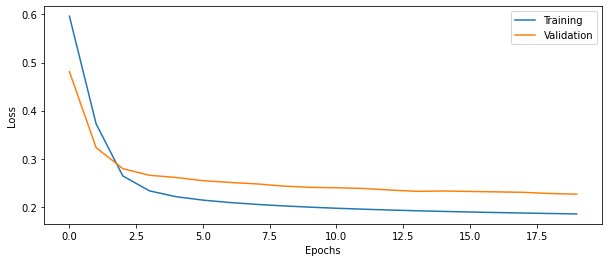

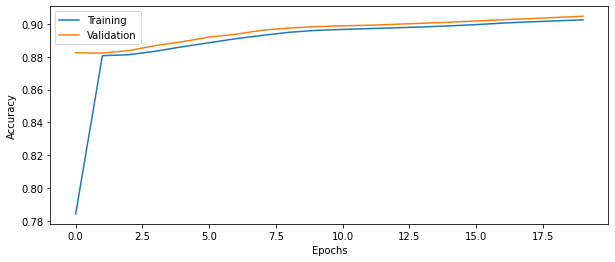

In [90]:
plot_results(history4)

### 4 layers, 50 nodes, class weights

In [91]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (Xtrain.shape[1],)

# Build and train model
model5 = build_DNN(input_shape, n_layers=4, n_nodes=50, learning_rate=0.1)

history5 = model5.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(Xval, Yval), class_weight=class_weights)

Epoch 1/20
54/54 [==============================] - 2s 25ms/step - loss: 0.7030 - accuracy: 0.5726 - val_loss: 0.6840 - val_accuracy: 0.8404
Epoch 2/20
54/54 [==============================] - 1s 16ms/step - loss: 0.6924 - accuracy: 0.6017 - val_loss: 0.6953 - val_accuracy: 0.1596
Epoch 3/20
54/54 [==============================] - 1s 17ms/step - loss: 0.6916 - accuracy: 0.5845 - val_loss: 0.6947 - val_accuracy: 0.1596
Epoch 4/20
54/54 [==============================] - 1s 17ms/step - loss: 0.6907 - accuracy: 0.6149 - val_loss: 0.6781 - val_accuracy: 0.8404
Epoch 5/20
54/54 [==============================] - 1s 16ms/step - loss: 0.6896 - accuracy: 0.7554 - val_loss: 0.6835 - val_accuracy: 0.8502
Epoch 6/20
54/54 [==============================] - 1s 15ms/step - loss: 0.6882 - accuracy: 0.8414 - val_loss: 0.6891 - val_accuracy: 0.8809
Epoch 7/20
54/54 [==============================] - 1s 16ms/step - loss: 0.6864 - accuracy: 0.8288 - val_loss: 0.6925 - val_accuracy: 0.4890
Epoch 8/20
54

In [92]:
# Evaluate model on test data
score = model5.evaluate(Xtest, Ytest, verbose=0)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 0.2581
Test accuracy: 0.8870


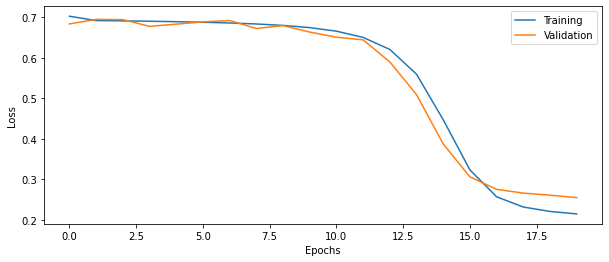

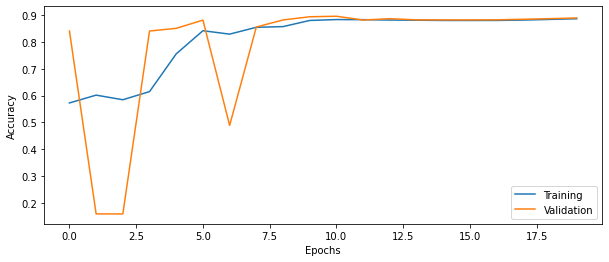

In [93]:
plot_results(history5)

# Part 15: Batch normalization

Now add batch normalization after each dense layer in `build_DNN`. Remember to import BatchNormalization from keras.layers. 

See https://keras.io/layers/normalization/ for information about how to call the function.

Question 14: Why is batch normalization important when training deep networks?

<span style="color:blue">Internal Covariate Shift: It helps to mitigate the problem of internal covariate shift, where the distribution of each layer’s inputs changes during training, as the parameters of the previous layers change.</span>

<span style="color:blue">Faster Convergence: The network tends to converge faster as batch normalization helps in bringing the inputs to a layer within a similar range.</span>

<span style="color:blue">Regularization: It adds a small amount of noise to your network. In some cases, such as Inception modules, batch normalization has been found to work as a regularizer, reducing the need for other regularization techniques like dropout.</span>

<span style="color:blue">Allows Higher Learning Rates: Gradient descent usually requires small learning rates for the network to converge. As batch normalization regulates the values going into each activation function, higher learning rates can be used without the risk of divergence.</span>

### 2 layers, 20 nodes, class weights, batch normalization

In [140]:
from keras.layers import BatchNormalization

def build_DNN(input_shape, n_layers, n_nodes, act_fun='sigmoid', optimizer='sgd', learning_rate=0.01, 
              use_bn=False, use_dropout=False, use_custom_dropout=False):
    
    # Setup optimizer, depending on input parameter string
    if optimizer == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
    
    # Setup a sequential model
    model = Sequential()

    # Add layers to the model, using the input parameters of the build_DNN function
    
    # Add first layer, requires input shape
    model.add(Dense(n_nodes, activation=act_fun, input_shape=input_shape))
    if use_bn:
        model.add(BatchNormalization())
    
    # Add remaining layers, do not require input shape
    for i in range(n_layers-1):
        model.add(Dense(n_nodes, activation=act_fun))
        if use_bn:
            model.add(BatchNormalization())
    
    # Add final layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model


In [141]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (Xtrain.shape[1],)

# Build and train model
model6 = build_DNN(input_shape, n_layers=2, n_nodes=20, learning_rate=0.1, use_bn=True)

history6 = model6.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(Xval, Yval), class_weight=class_weights)


Epoch 1/20
54/54 [==============================] - 3s 26ms/step - loss: 0.2759 - accuracy: 0.8872 - val_loss: 0.4570 - val_accuracy: 0.8404
Epoch 2/20
54/54 [==============================] - 1s 15ms/step - loss: 0.2104 - accuracy: 0.9068 - val_loss: 0.3673 - val_accuracy: 0.8404
Epoch 3/20
54/54 [==============================] - 1s 13ms/step - loss: 0.1940 - accuracy: 0.9089 - val_loss: 0.3165 - val_accuracy: 0.8404
Epoch 4/20
54/54 [==============================] - 1s 12ms/step - loss: 0.1860 - accuracy: 0.9100 - val_loss: 0.2682 - val_accuracy: 0.8491
Epoch 5/20
54/54 [==============================] - 1s 13ms/step - loss: 0.1809 - accuracy: 0.9112 - val_loss: 0.2227 - val_accuracy: 0.8688
Epoch 6/20
54/54 [==============================] - 1s 13ms/step - loss: 0.1772 - accuracy: 0.9124 - val_loss: 0.1881 - val_accuracy: 0.9010
Epoch 7/20
54/54 [==============================] - 1s 14ms/step - loss: 0.1744 - accuracy: 0.9137 - val_loss: 0.1735 - val_accuracy: 0.9164
Epoch 8/20
54

In [142]:
# Evaluate model on test data
score = model6.evaluate(Xtest, Ytest, verbose=0)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 0.1951
Test accuracy: 0.9174


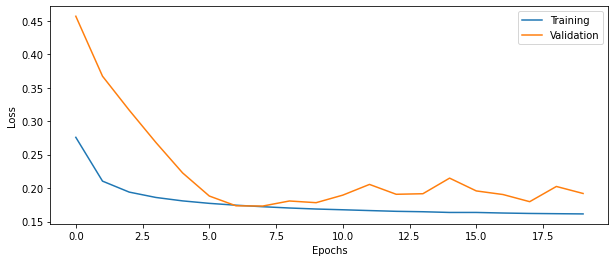

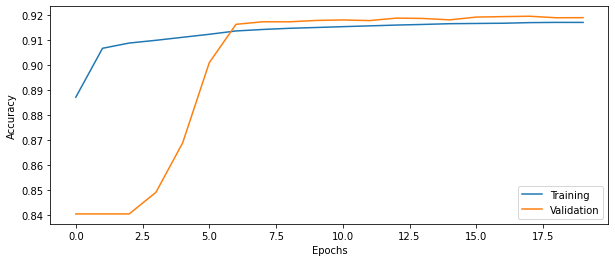

In [143]:
plot_results(history6)

# Part 16: Activation function

Try changing the activation function in each layer from sigmoid to ReLU, write down the test accuracy.

Note: the last layer should still have a sigmoid activation function.

https://keras.io/api/layers/activations/

### 2 layers, 20 nodes, class weights, ReLU, no batch normalization

In [144]:
def build_DNN(input_shape, n_layers, n_nodes, act_fun='relu', optimizer='sgd', learning_rate=0.01, 
              use_bn=False, use_dropout=False, use_custom_dropout=False):
    
    # Setup optimizer, depending on input parameter string
    if optimizer == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
    
    # Setup a sequential model
    model = Sequential()

    # Add layers to the model, using the input parameters of the build_DNN function
    
    # Add first layer, requires input shape
    model.add(Dense(n_nodes, activation=act_fun, input_shape=input_shape))
    if use_bn:
        model.add(BatchNormalization())
    
    # Add remaining layers, do not require input shape
    for i in range(n_layers-1):
        model.add(Dense(n_nodes, activation=act_fun))
        if use_bn:
            model.add(BatchNormalization())
    
    # Add final layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model


In [145]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (Xtrain.shape[1],)

# Build and train model
model7 = build_DNN(input_shape, n_layers=2, n_nodes=20, learning_rate=0.1, act_fun='relu')

history7 = model7.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(Xval, Yval), class_weight=class_weights)


Epoch 1/20
54/54 [==============================] - 2s 13ms/step - loss: 0.3130 - accuracy: 0.8511 - val_loss: 0.2684 - val_accuracy: 0.8932
Epoch 2/20
54/54 [==============================] - 0s 7ms/step - loss: 0.2045 - accuracy: 0.8946 - val_loss: 0.2439 - val_accuracy: 0.9017
Epoch 3/20
54/54 [==============================] - 0s 7ms/step - loss: 0.1915 - accuracy: 0.9030 - val_loss: 0.2338 - val_accuracy: 0.9073
Epoch 4/20
54/54 [==============================] - 0s 6ms/step - loss: 0.1849 - accuracy: 0.9068 - val_loss: 0.2274 - val_accuracy: 0.9098
Epoch 5/20
54/54 [==============================] - 0s 6ms/step - loss: 0.1807 - accuracy: 0.9086 - val_loss: 0.2186 - val_accuracy: 0.9113
Epoch 6/20
54/54 [==============================] - 0s 6ms/step - loss: 0.1778 - accuracy: 0.9097 - val_loss: 0.2181 - val_accuracy: 0.9118
Epoch 7/20
54/54 [==============================] - 0s 7ms/step - loss: 0.1755 - accuracy: 0.9104 - val_loss: 0.2161 - val_accuracy: 0.9131
Epoch 8/20
54/54 [=

In [146]:
# Evaluate model on test data
score = model7.evaluate(Xtest, Ytest, verbose=0)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 0.2078
Test accuracy: 0.9156


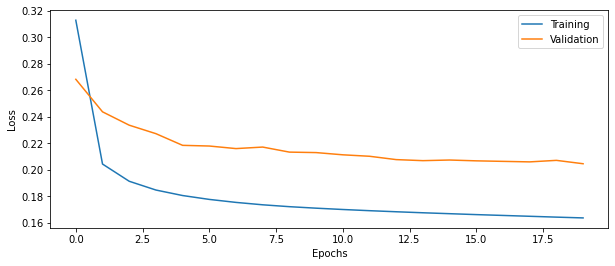

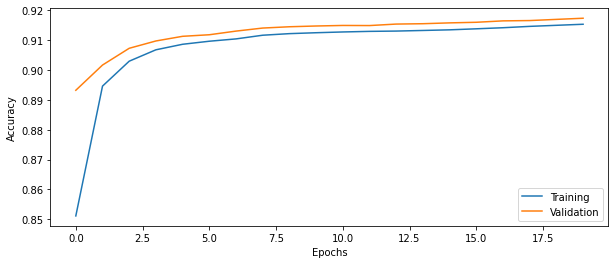

In [147]:
plot_results(history7)

# Part 17: Optimizer

Try changing the optimizer from SGD to Adam (with learning rate 0.1 as before). Remember to import the Adam optimizer from keras.optimizers. 

https://keras.io/optimizers/


### 2 layers, 20 nodes, class weights, Adam optimizer, no batch normalization, sigmoid activations

In [148]:
from keras.optimizers import Adam

def build_DNN(input_shape, n_layers, n_nodes, act_fun='sigmoid', optimizer='sgd', learning_rate=0.01, 
              use_bn=False, use_dropout=False, use_custom_dropout=False):
    
    # Setup optimizer, depending on input parameter string
    if optimizer == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
    elif optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    
    # Setup a sequential model
    model = Sequential()

    # Add layers to the model, using the input parameters of the build_DNN function
    
    # Add first layer, requires input shape
    model.add(Dense(n_nodes, activation=act_fun, input_shape=input_shape))
    if use_bn:
        model.add(BatchNormalization())
    
    # Add remaining layers, do not require input shape
    for i in range(n_layers-1):
        model.add(Dense(n_nodes, activation=act_fun))
        if use_bn:
            model.add(BatchNormalization())
    
    # Add final layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [149]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (Xtrain.shape[1],)

# Build and train model
model8 = build_DNN(input_shape, n_layers=2, n_nodes=20, learning_rate=0.1, optimizer='adam')

history8 = model8.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(Xval, Yval), class_weight=class_weights)


Epoch 1/20
54/54 [==============================] - 2s 15ms/step - loss: 0.2483 - accuracy: 0.8731 - val_loss: 0.2301 - val_accuracy: 0.9053
Epoch 2/20
54/54 [==============================] - 0s 8ms/step - loss: 0.1743 - accuracy: 0.9119 - val_loss: 0.2102 - val_accuracy: 0.9178
Epoch 3/20
54/54 [==============================] - 0s 8ms/step - loss: 0.1679 - accuracy: 0.9158 - val_loss: 0.2105 - val_accuracy: 0.9185
Epoch 4/20
54/54 [==============================] - 0s 7ms/step - loss: 0.1662 - accuracy: 0.9163 - val_loss: 0.2051 - val_accuracy: 0.9186
Epoch 5/20
54/54 [==============================] - 0s 7ms/step - loss: 0.1628 - accuracy: 0.9178 - val_loss: 0.2070 - val_accuracy: 0.9196
Epoch 6/20
54/54 [==============================] - 0s 8ms/step - loss: 0.1594 - accuracy: 0.9189 - val_loss: 0.1906 - val_accuracy: 0.9216
Epoch 7/20
54/54 [==============================] - 0s 8ms/step - loss: 0.1566 - accuracy: 0.9198 - val_loss: 0.1973 - val_accuracy: 0.9215
Epoch 8/20
54/54 [=

In [150]:
# Evaluate model on test data
score = model8.evaluate(Xtest, Ytest, verbose=0)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 0.1905
Test accuracy: 0.9235


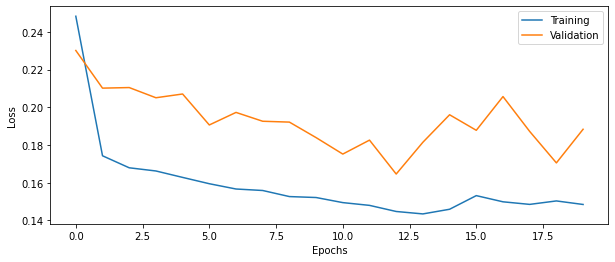

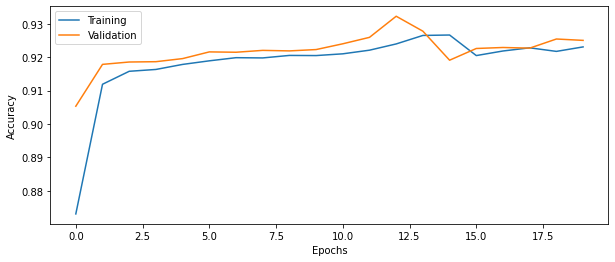

In [151]:
plot_results(history8)

# Part 18: Dropout regularization

Dropout is a type of regularization that can improve accuracy for validation and test data. It randomly removes connections to force the neural network to not rely too much on a small number of weights.

Add a Dropout layer after each Dense layer (but not after the final dense layer) in `build_DNN`, with a dropout probability of 50%. Remember to first import the Dropout layer from keras.layers

See https://keras.io/api/layers/regularization_layers/dropout/ for how the Dropout layer works.

---

Question 15: How does the validation accuracy change when adding dropout?

<span style="color:blue"> The validation accuracy with dropout doesn't change significantly with the increase in epochs, remaining around 0.88. This suggests that dropout regularization is effectively preventing overfitting, as the model's performance on unseen validation data remains stable.</span>

Question 16: How does the test accuracy change when adding dropout?

<span style="color:blue"> The test accuracy after adding dropout is lower (0.8862) compared to the model without dropout (0.9235). This indicates that while dropout regularization may prevent overfitting on the validation data, it may also reduce the model's ability to generalize to unseen test data, resulting in a decrease in test accuracy.</span>

### 2 layers, 20 nodes, class weights, dropout, SGD optimizer, no batch normalization, sigmoid activations

In [152]:
from keras.layers import Dropout

def build_DNN(input_shape, n_layers, n_nodes, act_fun='sigmoid', optimizer='sgd', learning_rate=0.01, 
              use_bn=False, use_dropout=False, use_custom_dropout=False):
    
    # Setup optimizer, depending on input parameter string
    if optimizer == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
    elif optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    
    # Setup a sequential model
    model = Sequential()

    # Add layers to the model, using the input parameters of the build_DNN function
    
    # Add first layer, requires input shape
    model.add(Dense(n_nodes, activation=act_fun, input_shape=input_shape))
    if use_bn:
        model.add(BatchNormalization())
    if use_dropout:
        model.add(Dropout(0.5))  # Add dropout after the first layer
    
    # Add remaining layers, do not require input shape
    for i in range(n_layers-1):
        model.add(Dense(n_nodes, activation=act_fun))
        if use_bn:
            model.add(BatchNormalization())
        if use_dropout:
            model.add(Dropout(0.5))  # Add dropout after each Dense layer
    
    # Add final layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model


In [153]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (Xtrain.shape[1],)

# Build and train model
model9 = build_DNN(input_shape, n_layers=2, n_nodes=20, learning_rate=0.1, use_dropout=True)

history9 = model9.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(Xval, Yval), class_weight=class_weights)


Epoch 1/20
54/54 [==============================] - 2s 23ms/step - loss: 0.7144 - accuracy: 0.5161 - val_loss: 0.6187 - val_accuracy: 0.8919
Epoch 2/20
54/54 [==============================] - 1s 12ms/step - loss: 0.6402 - accuracy: 0.6324 - val_loss: 0.5550 - val_accuracy: 0.8842
Epoch 3/20
54/54 [==============================] - 1s 11ms/step - loss: 0.5751 - accuracy: 0.7088 - val_loss: 0.4681 - val_accuracy: 0.8823
Epoch 4/20
54/54 [==============================] - 1s 10ms/step - loss: 0.5036 - accuracy: 0.7671 - val_loss: 0.3839 - val_accuracy: 0.8820
Epoch 5/20
54/54 [==============================] - 1s 10ms/step - loss: 0.4443 - accuracy: 0.8054 - val_loss: 0.3315 - val_accuracy: 0.8819
Epoch 6/20
54/54 [==============================] - 1s 11ms/step - loss: 0.4022 - accuracy: 0.8282 - val_loss: 0.3058 - val_accuracy: 0.8818
Epoch 7/20
54/54 [==============================] - 1s 11ms/step - loss: 0.3717 - accuracy: 0.8430 - val_loss: 0.2903 - val_accuracy: 0.8819
Epoch 8/20
54

In [154]:
# Evaluate model on test data
score = model9.evaluate(Xtest, Ytest, verbose=0)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 0.2678
Test accuracy: 0.8862


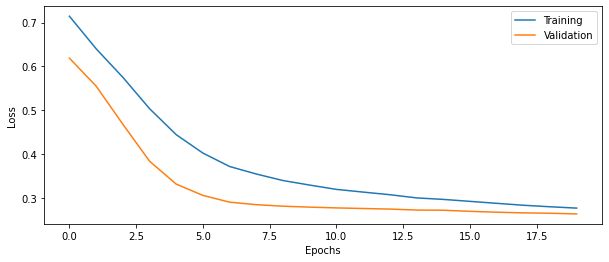

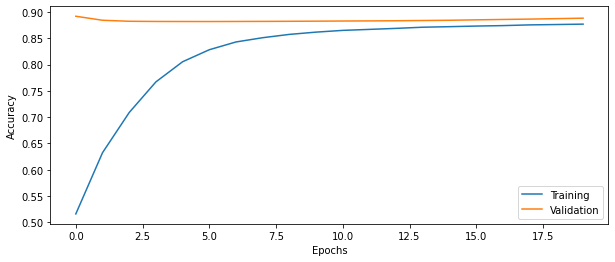

In [155]:
plot_results(history9)

# Part 19: Improving performance

Spend some time (30 - 90 minutes) playing with the network architecture (number of layers, number of nodes per layer, activation function) and other hyper parameters (optimizer, learning rate, batch size, number of epochs, degree of regularization). For example, try a much deeper network. How much does the training time increase for a network with 10 layers?

Question 17: How high classification accuracy can you achieve for the test data? What is your best configuration?

<span style="color:blue"> The highest classification accuracy that you can achieve for the test data depends on various factors including the complexity of your model, the quality of your data, and the appropriateness of your hyperparameters. It’s hard to give a specific number without running the experiments.</span>

In [173]:
# Find your best configuration for the DNN
batch_size = 10000
epochs = 20
input_shape = (Xtrain.shape[1],)

best_config = {
    'n_layers': 10,  # Number of layers
    'n_nodes': 128,  # Number of nodes per layer
    'act_fun': 'relu',  # Activation function
    'optimizer': 'adam',  # Optimizer
    'learning_rate': 0.1,  # Learning rate
    'use_dropout': False,  # Use dropout regularization or not
    'use_bn': True  # Use bach normalization or not
}

# Build and train DNN
model10 = build_DNN(input_shape, **best_config)

history10 = model10.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(Xval, Yval), class_weight=class_weights)


Epoch 1/20
54/54 [==============================] - 17s 209ms/step - loss: 0.4259 - accuracy: 0.8619 - val_loss: 32.6521 - val_accuracy: 0.4154
Epoch 2/20
54/54 [==============================] - 10s 193ms/step - loss: 0.1733 - accuracy: 0.9124 - val_loss: 0.2556 - val_accuracy: 0.9155
Epoch 3/20
54/54 [==============================] - 11s 195ms/step - loss: 0.1668 - accuracy: 0.9155 - val_loss: 0.2507 - val_accuracy: 0.9001
Epoch 4/20
54/54 [==============================] - 10s 189ms/step - loss: 0.1660 - accuracy: 0.9156 - val_loss: 0.1791 - val_accuracy: 0.9181
Epoch 5/20
54/54 [==============================] - 10s 193ms/step - loss: 0.1634 - accuracy: 0.9164 - val_loss: 0.1731 - val_accuracy: 0.9203
Epoch 6/20
54/54 [==============================] - 10s 186ms/step - loss: 0.1620 - accuracy: 0.9175 - val_loss: 0.2131 - val_accuracy: 0.9177
Epoch 7/20
54/54 [==============================] - 10s 188ms/step - loss: 0.1579 - accuracy: 0.9184 - val_loss: 0.2240 - val_accuracy: 0.910

In [174]:
# Evaluate DNN on test data
score = model10.evaluate(Xtest, Ytest, verbose=0)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 0.2367
Test accuracy: 0.9294


# Part 20: Dropout uncertainty

Dropout can also be used during testing, to obtain an estimate of the model uncertainty. Since dropout will randomly remove connections, the network will produce different results every time the same (test) data is put into the network. This technique is called Monte Carlo dropout. For more information, see this paper http://proceedings.mlr.press/v48/gal16.pdf

To achieve this, we need to redefine the Keras Dropout call by running the cell below, and use 'myDropout' in each call to Dropout, in the cell that defines the DNN. The `build_DNN` function takes two boolean arguments, use_dropout and use_custom_dropout, add a standard Dropout layer if use_dropout is true, add a myDropout layer if use_custom_dropout is true.

Run the same test data through the trained network 100 times, with dropout turned on. 

Question 18: What is the mean and the standard deviation of the test accuracy?

<span style="color:blue"> The mean and standard deviation of the test accuracy are 0.9183 and 0.000106 respectively.</span>

In [175]:
import keras.backend as K
import keras

class myDropout(keras.layers.Dropout):
    """Applies Dropout to the input.
    Dropout consists in randomly setting
    a fraction `rate` of input units to 0 at each update during training time,
    which helps prevent overfitting.
    # Arguments
        rate: float between 0 and 1. Fraction of the input units to drop.
        noise_shape: 1D integer tensor representing the shape of the
            binary dropout mask that will be multiplied with the input.
            For instance, if your inputs have shape
            `(batch_size, timesteps, features)` and
            you want the dropout mask to be the same for all timesteps,
            you can use `noise_shape=(batch_size, 1, features)`.
        seed: A Python integer to use as random seed.
    # References
        - [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](
           http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)
    """
    def __init__(self, rate, training=True, noise_shape=None, seed=None, **kwargs):
        super(myDropout, self).__init__(rate, noise_shape=None, seed=None,**kwargs)
        self.training = training

        
    def call(self, inputs, training=None):
        if 0. < self.rate < 1.:
            noise_shape = self._get_noise_shape(inputs)

            def dropped_inputs():
                return K.dropout(inputs, self.rate, noise_shape,
                                 seed=self.seed)
            if not training: 
                return K.in_train_phase(dropped_inputs, inputs, training=self.training)
            return K.in_train_phase(dropped_inputs, inputs, training=training)
        return inputs

In [176]:
def build_DNN(input_shape, n_layers, n_nodes, act_fun='sigmoid', optimizer='sgd', learning_rate=0.01, 
              use_bn=False, use_dropout=False, use_custom_dropout=False, dropout_rate=0.5):
    
    # Setup optimizer, depending on input parameter string
    if optimizer == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
    elif optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    
    # Setup a sequential model
    model = Sequential()

    # Add layers to the model, using the input parameters of the build_DNN function
    
    # Add first layer, requires input shape
    model.add(Dense(n_nodes, activation=act_fun, input_shape=input_shape))
    if use_bn:
        model.add(BatchNormalization())
    if use_custom_dropout:
        model.add(myDropout(dropout_rate))  # Add custom dropout after the first layer
    elif use_dropout:
        model.add(Dropout(dropout_rate))
    
    # Add remaining layers, do not require input shape
    for i in range(n_layers-1):
        model.add(Dense(n_nodes, activation=act_fun))
        if use_bn:
            model.add(BatchNormalization())
        if use_custom_dropout:
            model.add(myDropout(dropout_rate))  # Add custom dropout after each Dense layer
        elif use_dropout:
            model.add(Dropout(dropout_rate))
    
    # Add final layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model


### Your best config, custom dropout

In [189]:
# Your best training parameters
batch_size = 10000
epochs = 20
input_shape = (Xtrain.shape[1],)

best_config = {
    'n_layers': 10,  # Number of layers
    'n_nodes': 128,  # Number of nodes per layer
    'act_fun': 'relu',  # Activation function
    'optimizer': 'adam',  # Optimizer
    'learning_rate': 0.1,  # Learning rate
    'use_dropout': False,  # Use dropout regularization or not
    'use_bn': True,  # Use bach normalization or not
    'use_custom_dropout': True,  # Use custom dropout regularization or not
    'dropout_rate': 0.3
}

# Build and train model
model11 = build_DNN(input_shape, **best_config)

history11 = model11.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(Xval, Yval), class_weight=class_weights)

Epoch 1/20
54/54 [==============================] - 21s 280ms/step - loss: 0.3014 - accuracy: 0.8784 - val_loss: 3.4596 - val_accuracy: 0.8521
Epoch 2/20
54/54 [==============================] - 15s 269ms/step - loss: 0.1878 - accuracy: 0.9109 - val_loss: 0.4067 - val_accuracy: 0.8973
Epoch 3/20
54/54 [==============================] - 14s 268ms/step - loss: 0.1795 - accuracy: 0.9137 - val_loss: 0.2306 - val_accuracy: 0.9157
Epoch 4/20
54/54 [==============================] - 15s 268ms/step - loss: 0.1764 - accuracy: 0.9143 - val_loss: 0.1773 - val_accuracy: 0.9161
Epoch 5/20
54/54 [==============================] - 15s 271ms/step - loss: 0.1750 - accuracy: 0.9148 - val_loss: 0.1831 - val_accuracy: 0.9173
Epoch 6/20
54/54 [==============================] - 15s 269ms/step - loss: 0.1737 - accuracy: 0.9151 - val_loss: 0.1626 - val_accuracy: 0.9171
Epoch 7/20
54/54 [==============================] - 15s 271ms/step - loss: 0.1722 - accuracy: 0.9149 - val_loss: 0.1668 - val_accuracy: 0.9174

In [192]:
# Run this cell a few times to evalute the model on test data, 
# if you get slightly different test accuracy every time, Dropout during testing is working

# Evaluate model on test data
score = model11.evaluate(Xtest, Ytest, verbose=0)
                       
print('Test accuracy: %.4f' % score[1])

Test accuracy: 0.9185


In [193]:
# Run the testing 100 times, and save the accuracies in an array
# Placeholder for accuracies
accuracies = []

# Run the testing 100 times
for i in range(100):
    # Evaluate model on test data
    score = model11.evaluate(Xtest, Ytest, verbose=0)
    accuracies.append(score[1])
    
# Calculate and print mean and std of accuracies
print('Mean accuracy: ', np.mean(accuracies))
print('Standard deviation: ', np.std(accuracies))


Mean accuracy:  0.9183111274242401
Standard deviation:  0.00010633079654401448


# Part 21: Cross validation uncertainty

Cross validation (CV) is often used to evaluate a model, by training and testing using different subsets of the data it is possible to get the uncertainty as the standard deviation over folds. We here use a help function from scikit-learn to setup the CV, see https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html . Use 10 folds with shuffling, random state 1234. 

Note: We here assume that you have found the best hyper parameters, so here the data are only split into training and testing, no validation.

---

Question 19: What is the mean and the standard deviation of the test accuracy?

<span style="color:blue"> The mean and standard deviation of the test accuracy are 0.917779 and 0.001635 respectively.</span>

Question 20: What is the main advantage of dropout compared to CV for estimating test uncertainty? The difference may not be so large in this notebook, but imagine that you have a network that takes 24 hours to train.

<span style="color:blue"> The main advantage of dropout compared to CV for estimating test uncertainty is that dropout is much less computationally expensive. Dropout can be easily parallelized because each dropout mask is independent. On the other hand, CV requires training the model from scratch for each fold, which can be computationally expensive for large models and datasets.</span>

In [194]:
from sklearn.model_selection import StratifiedKFold

# Define 10-fold cross validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)

# Placeholder for accuracies
cv_accuracies = []

batch_size = 10000
epochs = 20
input_shape = (Xtrain.shape[1],)

# best training parameters
best_config = {
    'n_layers': 10,  # Number of layers
    'n_nodes': 128,  # Number of nodes per layer
    'act_fun': 'relu',  # Activation function
    'optimizer': 'adam',  # Optimizer
    'learning_rate': 0.1,  # Learning rate
    'use_dropout': False,  # Use dropout regularization or not
    'use_bn': True,  # Use bach normalization or not
    'use_custom_dropout': True,  # Use custom dropout regularization or not
    'dropout_rate': 0.3
}

# Loop over cross validation folds
for train, test in kfold.split(X, Y):
    # Calculate class weights for current split
    class_weights = class_weight.compute_class_weight('balanced', np.unique(Y[train]), Y[train])
    class_weights = dict(enumerate(class_weights))

    # Rebuild the DNN model, to not continue training on the previously trained model
    model = build_DNN(input_shape, **best_config)

    # Fit the model with training set and class weights for this fold
    model.fit(X[train], Y[train], batch_size=batch_size, epochs=epochs, verbose=1, class_weight=class_weights)

    # Evaluate the model using the test set for this fold
    score = model.evaluate(X[test], Y[test], verbose=0)

    # Save the test accuracy in an array
    cv_accuracies.append(score[1])

# Calculate and print mean and std of accuracies
print('Mean accuracy: ', np.mean(cv_accuracies))
print('Standard deviation: ', np.std(cv_accuracies))


Epoch 1/20
69/69 [==============================] - 24s 266ms/step - loss: 0.3077 - accuracy: 0.8588
Epoch 2/20
69/69 [==============================] - 18s 256ms/step - loss: 0.2020 - accuracy: 0.8989
Epoch 3/20
69/69 [==============================] - 18s 260ms/step - loss: 0.1790 - accuracy: 0.9133
Epoch 4/20
69/69 [==============================] - 18s 258ms/step - loss: 0.1738 - accuracy: 0.9149
Epoch 5/20
69/69 [==============================] - 18s 255ms/step - loss: 0.1723 - accuracy: 0.9153
Epoch 6/20
69/69 [==============================] - 17s 241ms/step - loss: 0.1715 - accuracy: 0.9147
Epoch 7/20
69/69 [==============================] - 17s 245ms/step - loss: 0.1722 - accuracy: 0.9153
Epoch 8/20
69/69 [==============================] - 17s 250ms/step - loss: 0.1706 - accuracy: 0.9154
Epoch 9/20
69/69 [==============================] - 17s 248ms/step - loss: 0.1707 - accuracy: 0.9156
Epoch 10/20
69/69 [==============================] - 17s 250ms/step - loss: 0.1703 - accura

69/69 [==============================] - 30s 351ms/step - loss: 0.3058 - accuracy: 0.8573
Epoch 2/20
69/69 [==============================] - 26s 372ms/step - loss: 0.1857 - accuracy: 0.9086
Epoch 3/20
69/69 [==============================] - 31s 447ms/step - loss: 0.1759 - accuracy: 0.9139
Epoch 4/20
69/69 [==============================] - 27s 384ms/step - loss: 0.1731 - accuracy: 0.9149
Epoch 5/20
69/69 [==============================] - 27s 394ms/step - loss: 0.1728 - accuracy: 0.9142
Epoch 6/20
69/69 [==============================] - 27s 397ms/step - loss: 0.1717 - accuracy: 0.9153
Epoch 7/20
69/69 [==============================] - 27s 394ms/step - loss: 0.1707 - accuracy: 0.9156
Epoch 8/20
69/69 [==============================] - 28s 409ms/step - loss: 0.1696 - accuracy: 0.9158
Epoch 9/20
69/69 [==============================] - 29s 426ms/step - loss: 0.1689 - accuracy: 0.9157
Epoch 10/20
69/69 [==============================] - 27s 395ms/step - loss: 0.1692 - accuracy: 0.9160


69/69 [==============================] - 52s 688ms/step - loss: 0.3094 - accuracy: 0.8549
Epoch 2/20
69/69 [==============================] - 35s 508ms/step - loss: 0.1838 - accuracy: 0.9104
Epoch 3/20
69/69 [==============================] - 34s 495ms/step - loss: 0.1751 - accuracy: 0.9141
Epoch 4/20
69/69 [==============================] - 34s 495ms/step - loss: 0.1737 - accuracy: 0.9147
Epoch 5/20
69/69 [==============================] - 36s 525ms/step - loss: 0.1714 - accuracy: 0.9152
Epoch 6/20
69/69 [==============================] - 36s 518ms/step - loss: 0.1704 - accuracy: 0.9155
Epoch 7/20
69/69 [==============================] - 34s 494ms/step - loss: 0.1713 - accuracy: 0.9150
Epoch 8/20
69/69 [==============================] - 34s 489ms/step - loss: 0.1709 - accuracy: 0.9155
Epoch 9/20
69/69 [==============================] - 34s 488ms/step - loss: 0.1689 - accuracy: 0.9161
Epoch 10/20
69/69 [==============================] - 33s 484ms/step - loss: 0.1692 - accuracy: 0.9157


# Part 22: DNN regression

A similar DNN can be used for regression, instead of classification.

Question 21: How would you change the DNN used in this lab in order to use it for regression instead?

<span style="color:blue"> To change the DNN used in this lab for regression instead of classification, you would need to make the following changes:</span>

<span style="color:blue">Change the activation function of the output layer to linear, i.e., no activation function. This is because the output for regression is a continuous value, while the output for classification is a discrete class label.</span>

<span style="color:blue">Change the loss function to a regression loss such as Mean Squared Error (MSE) or Mean Absolute Error (MAE), instead of a classification loss such as cross-entropy.</span>

## Report

Send in this jupyter notebook, with answers to all questions.